In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('/kaggle/input/medical-insurance-cost-dataset/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 1. Подготовка данных

In [3]:
# Проверка пропущенных значений и выбросов

missing_ratio = data.isnull().mean() * 100
print("Доля пропусков по колонкам (%):")
for col, ratio in missing_ratio.items():
    print(f"  {col}: {ratio:.2f}%")
print()

numeric_cols = data.select_dtypes(include='number').columns

def get_outlier_info(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers.sum(), lower_bound, upper_bound

outlier_info = {}
print("Анализ выбросов по числовым признакам:")
for col in numeric_cols:
    n_out, lb, ub = get_outlier_info(data[col])
    outlier_info[col] = n_out
    print(f"  {col}")
    print(f"    Выбросов: {n_out}")
    print(f"    Нижняя граница: {lb:.2f}")
    print(f"    Верхняя граница: {ub:.2f}")
    print("-" * 30)
print()

# Замена выбросов на границы
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Приведение категориальных признаков к числовым

print("Категориальные колонки:")
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    print(f"  {col}: {data[col].nunique()} класса")
print()

categorical_cols_bin = ['sex', 'smoker']
categorical_cols_multi = ['region']

for col in categorical_cols_multi:
    unique_vals = data[col].dropna().unique()
    data = pd.get_dummies(data, columns=[col], dtype=int)
    for val in unique_vals:
        data[f'{col}_{val}'] = data[f'{col}_{val}'].astype(int)

for col in categorical_cols_bin:
    unique_vals = data[col].dropna().unique()
    mapping = {unique_vals[0]: 0, unique_vals[1]: 1}
    print(col)
    print(f"  {mapping}")
    print()
    data[col] = data[col].map(mapping)

Доля пропусков по колонкам (%):
  age: 0.00%
  sex: 0.00%
  bmi: 0.00%
  children: 0.00%
  smoker: 0.00%
  region: 0.00%
  charges: 0.00%

Анализ выбросов по числовым признакам:
  age
    Выбросов: 0
    Нижняя граница: -9.00
    Верхняя граница: 87.00
------------------------------
  bmi
    Выбросов: 9
    Нижняя граница: 13.70
    Верхняя граница: 47.29
------------------------------
  children
    Выбросов: 0
    Нижняя граница: -3.00
    Верхняя граница: 5.00
------------------------------
  charges
    Выбросов: 139
    Нижняя граница: -13109.15
    Верхняя граница: 34489.35
------------------------------

Категориальные колонки:
  sex: 2 класса
  smoker: 2 класса
  region: 4 класса

sex
  {'female': 0, 'male': 1}

smoker
  {'yes': 0, 'no': 1}



Пропущенных значений в данных не оказалось, поэтому этот этап обработки пропускаем

В двух колонках обнаружены выбросы. Так как в последствии собираемся использовать регрессию, то от них необходимо избавиться. Выбросы создают аномально большие ошибки, что плохо сказывается на подборе весов. Избавляться от выбросов будем путем замены их на предельные значения.

В данных 3 категориальных колонки: sex и smoker - бинарные, region - мультиклассовая.
Бинарные колонки закодируем с помощью 1 и 0, а колонку регион с помощью one hot (ее нельзя упорядочить, поэтому label использовать не можем)

In [4]:
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,0,16884.92400,0,0,0,1
1,18,1,33.770,1,1,1725.55230,0,0,1,0
2,28,1,33.000,3,1,4449.46200,0,0,1,0
3,33,1,22.705,0,1,21984.47061,0,1,0,0
4,32,1,28.880,0,1,3866.85520,0,1,0,0


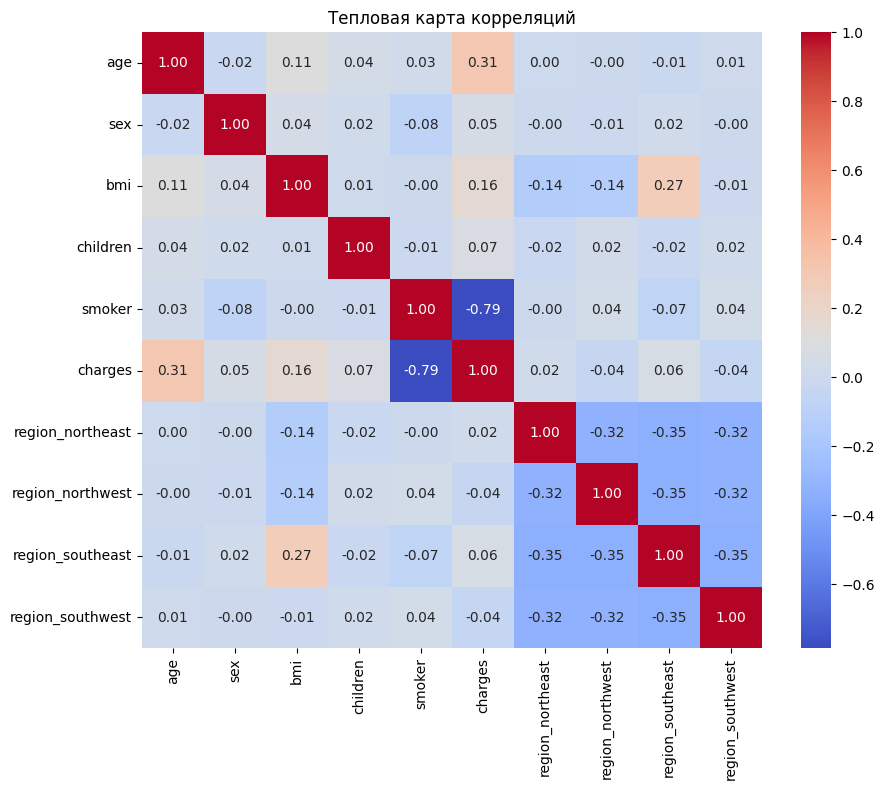

In [ ]:
# вычисление попарной корреляции

correlation_matrix = data.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Тепловая карта корреляций")
plt.show()

Обычно обращаем внимание на корреляцию >=|0.8|. На карте виден только один такой случай - корреляция между charges и smoker. Однако в нашем случае это хорошо, так как наблюдаемая корреляция является корреляцией между признаком и таргетом, с ней ничего делать не нужно. Высокой корреляции между признаками не обнаружено

# 2. Многомерная линейная регрессия

## Аналитическое решение регрессии
Модель регрессии $$ f(x, w) = \sum_{i=1}^{n} w_i x_i = Xw $$
Функционал потерь $$ Q(w) = \sum_{i=1}^{\ell} (f(x_i, w) - y_i)^2 = ||Xw - y||^2 \rightarrow \min_{w} $$
Градиент функционала потерь $$ \frac{\partial Q}{\partial w} = 2X^T(Xw-y) $$
Для поиска точки минимума, приравниваем градиент к нулю.
$$
2X^T(Xw-y) = 0
$$

$$
X^TXw = X^Ty
$$

$$
w^* = (X^TX)^{-1}X^Ty
$$

In [6]:
y = data['charges'].values
X_raw = data.drop(columns=['charges']).values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

X_train = np.column_stack([np.ones(X_train_scaled.shape[0]), X_train_scaled])
X_test = np.column_stack([np.ones(X_test_scaled.shape[0]), X_test_scaled])

XTX = X_train.T @ X_train
XTy = X_train.T @ y_train

if np.linalg.matrix_rank(XTX) == XTX.shape[0]:
    w_analytic = np.linalg.solve(XTX, XTy)
else:
    w_analytic = np.linalg.pinv(X_train) @ y_train

print("Аналитическое решение (коэффициенты):")
for i, w in enumerate(w_analytic):
    print(f"  w[{i}] = {w:.6f}")
print()

Аналитическое решение (коэффициенты):
  w[0] = 12566.865616
  w[1] = 3185.039012
  w[2] = -63.903919
  w[3] = 1377.163997
  w[4] = 464.550705
  w[5] = -8017.685110
  w[6] = 192.136220
  w[7] = 33.133063
  w[8] = -82.422527
  w[9] = -141.328460



## Градиентный спуск

$w^{(0)}$ - начальное приближение
$\lambda$ - размер градиентного шага

$w^{(k+1)} = w^{(k)} - \lambda \cdot \frac{\partial Q}{\partial w}|_{w=w^{(k)}}$

Остановка просходит в случаях:
* градиент близок к нулю
* изменение параметров близко к нулю
* достигнуто ограничительное число итераций

In [7]:
def gradient_descent(X, y, lr=0.001, n_iter=10000, tol=1e-6, verbose=False):
    m, n = X.shape
    w = np.zeros(n)
    prev_cost = float('inf')
    
    for i in range(n_iter):
        y_pred = X @ w
        error = y_pred - y
        cost = np.mean(error ** 2)  # MSE
        
        # Градиент MSE: (2/m) * X^T (Xw - y)
        grad = (2.0 / m) * (X.T @ error)
        w -= lr * grad
        
        if verbose and i % 1000 == 0:
            print(f"  Итерация {i}: MSE = {cost:.6f}")
        
        # Проверка сходимости
        if abs(prev_cost - cost) < tol:
            if verbose:
                print(f"  Сходимость достигнута на итерации {i}")
            break
        prev_cost = cost
    
    return w, cost

w_gd, final_cost = gradient_descent(X_train, y_train, lr=0.01, n_iter=1000, tol=1e-7)

print("Решение методом градиентного спуска (коэффициенты):")
for i, w in enumerate(w_gd):
    print(f"  w[{i}] = {w:.6f}")

Решение методом градиентного спуска (коэффициенты):
  w[0] = 12566.865091
  w[1] = 3185.038413
  w[2] = -63.903227
  w[3] = 1377.163839
  w[4] = 464.551144
  w[5] = -8017.683986
  w[6] = 192.136170
  w[7] = 33.132901
  w[8] = -82.422297
  w[9] = -141.328486


# 3. Добавление регуляризации

## Аналитическое решение

**Гребневая регрессия**
$$
Q_{L_2}(w) = ||Xw - y||^2 + \alpha ||w||_2^2 \rightarrow \min_{w}
$$

$$
||a||_2 = \sqrt{\sum_{i=1}^{n} a_i^2}
$$

Имеет аналитическое решение
$$
w^* = (X^TX + \alpha I)^{-1}X^Ty
$$
где $I$ - единичная матрица

Градиент
$$
\frac{\partial Q_{L_2}}{\partial w} = 2 X^T (Xw - y) + 2 \alpha w
$$


In [8]:
def ridge_analytic(X, y, alpha):
    m, n = X.shape
    # Матрица регуляризации: 0 для bias, 1 для остальных
    R = np.eye(n)
    R[0, 0] = 0 
    
    A = X.T @ X + alpha * R
    b = X.T @ y
    w = np.linalg.solve(A, b)
    return w

alpha = 1.0

w_ridge_analytic = ridge_analytic(X_train, y_train, alpha)

print("Аналитическое решение (Ridge):")
for i, w in enumerate(w_ridge_analytic):
    print(f"  w[{i}] = {w:.6f}")
print()

Аналитическое решение (Ridge):
  w[0] = 12566.865616
  w[1] = 3181.817960
  w[2] = -63.296489
  w[3] = 1376.041820
  w[4] = 464.427302
  w[5] = -8009.954177
  w[6] = 191.892718
  w[7] = 32.864897
  w[8] = -81.901429
  w[9] = -141.351782



## Градиентный спуск с регуляризацией

In [9]:
def ridge_gradient_descent(X, y, alpha, lr=0.01, n_iter=10000, tol=1e-7, verbose=False):
    m, n = X.shape
    w = np.zeros(n)
    prev_cost = float('inf')

    reg_mask = np.ones(n)
    reg_mask[0] = 0
    
    for i in range(n_iter):
        y_pred = X @ w
        error = y_pred - y
        mse = np.mean(error ** 2)

        grad_mse = (2.0 / m) * (X.T @ error)
        grad_reg = (2.0 * alpha / m) * (reg_mask * w)
        grad = grad_mse + grad_reg
        
        w -= lr * grad
        
        cost = mse + alpha * np.sum((reg_mask * w) ** 2)
        
        if verbose and i % 2000 == 0:
            print(f"  Итерация {i}: Loss = {cost:.6f}")
        
        if abs(prev_cost - cost) < tol:
            if verbose:
                print(f"  Сходимость на итерации {i}")
            break
        prev_cost = cost
    
    return w, cost

w_ridge_gd, loss_gd = ridge_gradient_descent(X_train, y_train, alpha=alpha, lr=0.01, n_iter=20000)

print("Численное решение (Ridge, градиентный спуск):")
for i, w in enumerate(w_ridge_gd):
    print(f"  w[{i}] = {w:.6f}")

Численное решение (Ridge, градиентный спуск):
  w[0] = 12566.865616
  w[1] = 3181.817960
  w[2] = -63.296489
  w[3] = 1376.041820
  w[4] = 464.427302
  w[5] = -8009.954177
  w[6] = 191.892718
  w[7] = 32.864897
  w[8] = -81.901429
  w[9] = -141.351782


# 4. Оценка обобщающей способности

## Константная модель

In [10]:
y_mean = np.mean(y_train)
y_pred_const = np.full_like(y_test, y_mean)
mse_const = np.mean((y_test - y_pred_const) ** 2)
ss_res_const = np.sum((y_test - y_pred_const) ** 2)
ss_tot = np.sum((y_test - y_mean) ** 2)  # y_mean — из train
r2_const = 1 - (ss_res_const / ss_tot)

## из пункта 2

In [12]:
y_pred_analytic = X_test @ w_analytic
mse_analytic = np.mean((y_test - y_pred_analytic) ** 2)
ss_res_analytic = np.sum((y_test - y_pred_analytic) ** 2)
r2_analytic = 1 - (ss_res_analytic / ss_tot)

## из пункта 3

In [14]:
y_pred_ridge = X_test @ w_ridge_gd
mse_ridge = np.mean((y_test - y_pred_ridge) ** 2)
ss_res_ridge = np.sum((y_test - y_pred_ridge) ** 2)
r2_ridge = 1 - (ss_res_ridge / ss_tot)

In [15]:
print("Сравнение моделей на тестовых данных:")
print(f"{'Модель':<30} {'MSE':>12} {'R²':>10}")
print("-" * 42)
print(f"{'Константная (среднее)':<30} {mse_const:>12,.2f} {r2_const:>10.4f}")
print(f"{'Линейная регрессия':<30} {mse_analytic:>12,.2f} {r2_analytic:>10.4f}")
print(f"{'Ridge (alpha=1.0)':<30} {mse_ridge:>12,.2f} {r2_ridge:>10.4f}")

Сравнение моделей на тестовых данных:
Модель                                  MSE         R²
------------------------------------------
Константная (среднее)          108,747,335.01     0.0000
Линейная регрессия             23,437,328.29     0.7845
Ridge (alpha=1.0)              23,442,766.64     0.7844


Модель линейной регрессии существенно превосходит константную (базовую) модель как по MSE, так и по $R^2$, что свидетельствует о её способности улавливать зависимости в данных. Ridge-регрессия с $(\alpha = 1.0)$ показывает практически идентичное качество, что указывает на слабое влияние регуляризации при данном значении гиперпараметра — вероятно, из-за отсутствия сильной мультиколлинеарности или переобучения. Таким образом, обычная линейная регрессия уже обеспечивает эффективное и достаточно устойчивое решение для данной задачи.